<a href="https://colab.research.google.com/github/mrrahul011/EIP-Session-4/blob/master/Resnet18_withcutout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import MaxPooling2D, AveragePooling2D, Input, Flatten,GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# Training params.
batch_size = 32
epochs = 50
data_augmentation = True
#random_erasing = True
#pixel_level = False

In [0]:
# Network architecture params.
num_classes = 10
num_filters = 16
num_blocks = 4
num_sub_blocks = 2
use_max_pool = False

In [0]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
# Input image dimensions.
# We assume data format "channels_last".
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

if K.image_data_format() == 'channels_first':
    img_rows = x_train.shape[2]
    img_cols = x_train.shape[3]
    channels = x_train.shape[1]
    x_train = x_train.reshape(x_train.shape[0], channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    img_rows = x_train.shape[1]
    img_cols = x_train.shape[2]
    channels = x_train.shape[3]
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
# Network architecture params.
num_classes = 10
num_filters = 16
num_blocks = 4
num_sub_blocks = 2
use_max_pool = False

# Start model definition.
inputs = Input(shape=input_shape)
x = Conv2D(num_filters,
           kernel_size=3,
           padding='same',
           strides=1,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Orig paper uses max pool after 1st conv.
# Reaches up 87% acc if use_max_pool = True.
# Cifar10 images are already too small at 32x32 to be maxpooled. So, we skip.
#if use_max_pool:
#    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
#    num_blocks = 3

# Instantiate convolutional base (stack of blocks).
for i in range(num_blocks):
    for j in range(num_sub_blocks-1):
        strides = 1
        #is_first_layer_but_not_first_block = j == 0 and i > 0
        #if is_first_layer_but_not_first_block:
        if (j == 0 and i>0):
            strides = 2
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        #if is_first_layer_but_not_first_block:
        if (j == 0 and i>0):
            x = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(x)
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)

    num_filters = 2 * num_filters

# Add classifier on top.
x = Conv2D(10,1)(x)
x = GlobalAveragePooling2D()(x)
#x = AveragePooling2D(pool_size=4)(x)
#y = Flatten()(x)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal')(x)
# Instantiate and compile model.
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr = 0.001),
              metrics=['accuracy'])
model.summary()















Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
______________________________________________________________________________

In [0]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_resnet_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate decaying.
checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


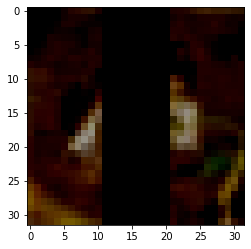

In [0]:
def cutout(img):
    MAX_CUTS = 2  # chance to get more cuts
    MAX_LENGTH_MULTIPLIER = 5  # change to get larger cuts ; 16 for cifar 10, 8 for cifar 100

    height = img.shape[1]
    width = img.shape[2]

    # normalize before adding the mask
    mean = img.mean(keepdims=True)
    img -= mean

    mask = np.ones((height, width), np.float32)
    nb_cuts = np.random.randint(0, MAX_CUTS + 1)

    for i in range(nb_cuts):
        y = np.random.randint(height)
        x = np.random.randint(width)
        length = 4 * np.random.randint(1, MAX_LENGTH_MULTIPLIER + 1)

        y1 = np.clip(y - length // 2, 0, height)
        y2 = np.clip(y + length // 2, 0, height)
        x1 = np.clip(x - length // 2, 0, width)
        x2 = np.clip(x + length // 2, 0, width)

        mask[y1: y2, x1: x2] = 0.

    # apply mask
    img = img * mask

    # denormalize
    img += mean

    return img

x = cutout(x_train[0])
plt.imshow(x)
plt.show()

In [0]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        preprocessing_function= cutout)


Using real-time data augmentation.


In [0]:
 # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                      
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

Epoch 1/50
1563/1563 [==============================] - 84s 54ms/step - loss: 0.8807 - acc: 0.7404 - val_loss: 0.6411 - val_acc: 0.8448

Epoch 00001: val_loss did not improve from 0.54452
Epoch 2/50
1563/1563 [==============================] - 83s 53ms/step - loss: 0.8058 - acc: 0.7671 - val_loss: 0.6114 - val_acc: 0.8534

Epoch 00002: val_loss did not improve from 0.54452
Epoch 3/50
1563/1563 [==============================] - 84s 54ms/step - loss: 0.7837 - acc: 0.7748 - val_loss: 0.6104 - val_acc: 0.8519

Epoch 00003: val_loss did not improve from 0.54452
Epoch 4/50
1563/1563 [==============================] - 83s 53ms/step - loss: 0.7780 - acc: 0.7777 - val_loss: 0.6047 - val_acc: 0.8537

Epoch 00004: val_loss did not improve from 0.54452
Epoch 5/50
1563/1563 [==============================] - 84s 54ms/step - loss: 0.7622 - acc: 0.7841 - val_loss: 0.6016 - val_acc: 0.8599

Epoch 00005: val_loss did not improve from 0.54452
Epoch 6/50
1563/1563 [==============================] - 83s 

In [0]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 2s 216us/step
Test loss: 0.47415243117809297
Test accuracy: 0.8884
